# MFP Nutrition Survival Analysis
by: Andy Luc

## Business case:
Health and fitness has always been a topic of interest to me and I am fairly active when it comes to staying in shape. Part of that journey involves the consistency of tracking nutritional intake. One of the most popular apps today is MyFitnessPal, which tracks this on a daily basis.

Based on only user inputs of daily food intake and a target goal:
1. Can we predict when or if a user decides to churn or quit using the app?

2. Is there a certain nutritional item that contributes to a user quitting the platform?


In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from lifelines import CoxPHFitter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functions import (json, pandas, get_totals, get_goals, merge, 
                       get_full_parse, add_prev_date, find_date)
plt.style.use('seaborn')
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Viewing the raw data file:

In [2]:
data = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userid','diary_date','food_entries','daily_goal'])
data.head()

,userid,diary_date,food_entries,daily_goal
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [3]:
# Number of unique users
len(data['userid'].unique())

9896

## Analyzing and Parsing Data
Since we are concerned with when a user decides to stop using the MyFitnessPal program based on their input attributes, I am focusing on the `diary_date` and `daily_goal` columns. First, we need to parse the nested dictionary within the `daily_goal` column.

In [4]:
# Extracting only the dialy_goals column
d_goal = data.drop(['userid', 'diary_date','food_entries'], axis=1)

In [5]:
# Loading into json format
f = json.loads(d_goal['daily_goal'][0])
f

{'total': [{'name': 'Calories', 'value': 2924},
  {'name': 'Carbs', 'value': 340},
  {'name': 'Fat', 'value': 114},
  {'name': 'Protein', 'value': 186},
  {'name': 'Sodium', 'value': 3658},
  {'name': 'Sugar', 'value': 109}],
 'goal': [{'name': 'Calories', 'value': 3173},
  {'name': 'Carbs', 'value': 396},
  {'name': 'Fat', 'value': 105},
  {'name': 'Protein', 'value': 160},
  {'name': 'Sodium', 'value': 2300},
  {'name': 'Sugar', 'value': 119}]}

### Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar

In [6]:
# Creates list of keys and values from the first dictionary, and zips them together
total_dict = get_totals(f)

# Creates list of keys and values from the second dictionary, and zips them together
goal_dict = get_goals(f)

# Combines new keys and values for 'Total' and 'Goals' into single dictionary
merge(total_dict, goal_dict)

# Iterrates through entire parsed dataframe and appends merged rows
full_list = get_full_parse(d_goal, f)

In [7]:
# Putting it back into a pandas dataframe
full_df = pd.DataFrame(full_list)
full_df.head()

,goal_calcium,goal_calories,goal_carbs,goal_chol,goal_fat,goal_fiber,goal_iron,goal_mon fat,goal_ply fat,goal_potass.,...,total_mon fat,total_ply fat,total_potass.,total_protein,total_sat fat,total_sodium,total_sugar,total_trn fat,total_vit a,total_vit c
0,NaN,3173.0,396.0,NaN,105.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,186.0,NaN,3658.0,109.0,NaN,NaN,NaN
1,NaN,1572.0,196.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.0,NaN,855.0,63.0,NaN,NaN,NaN
2,NaN,1832.0,229.0,NaN,61.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,114.0,NaN,2215.0,100.0,NaN,NaN,NaN
3,NaN,1685.0,210.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,98.0,NaN,1765.0,105.0,NaN,NaN,NaN
4,NaN,1597.0,199.0,NaN,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,202.0,NaN,1101.0,71.0,NaN,NaN,NaN


In [8]:
# Merging the original dataframe with the newly parsed daily_goal column
conn = pd.concat([data, full_df], axis=1)

In [9]:
# Looking at the number of null values for each column
conn.isna().sum()

userid                 0
diary_date             0
food_entries           0
daily_goal             0
goal_calcium      564262
goal_calories          7
goal_carbs         14145
goal_chol         568935
goal_fat           17859
goal_fiber        344347
goal_iron         558171
goal_mon fat      587096
goal_ply fat      586693
goal_potass.      567771
goal_protein        7321
goal_sat fat      570611
goal_sodium       196659
goal_sugar        218272
goal_trn fat      585359
goal_vit a        586413
goal_vit c        584701
total_calcium     564262
total_calories        26
total_carbs        14146
total_chol        568935
total_fat          17866
total_fiber       344349
total_iron        558171
total_mon fat     586759
total_ply fat     586426
total_potass.     567771
total_protein       7331
total_sat fat     570611
total_sodium      196660
total_sugar       218270
total_trn fat     585359
total_vit a       586413
total_vit c       584701
dtype: int64

In [10]:
# Dropping columns which have high null values which are not beneficial to the features being used
clean_df = conn.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                       'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                       'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                       'total_calcium','total_chol','total_iron','total_mon fat',
                       'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                       'total_vit a','total_vit c'], axis=1)

In [11]:
# Fill the remaining null values of each nutrient with 0
clean_df.fillna(0, inplace=True)

In [12]:
# Changing diary_date column to a datetime type
clean_df['diary_date'] = pd.to_datetime(clean_df['diary_date'])

Add additional columns:
- `total_sum`: Total sum of input values for the day
- `goal_sum`: Total sum of goal values for the day
- `achievement`: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [13]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

clean_df['total_sum'] = clean_df[total_s].apply(np.sum, axis=1)
clean_df['goal_sum'] = clean_df[goal_s].apply(np.sum, axis=1)
clean_df['achievement'] = np.where(abs((clean_df['total_sum'] - 
                                          clean_df['goal_sum']) / 
                                          clean_df['goal_sum']) <= 0.1, 1, 0)

Creating a new column with the previous date of the `diary_date` column. This is important to calculate churn rate.

In [ ]:
add_prev_date(clean_df)

In [15]:
clean_df.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0,7331.0,6253.0,0,2014-09-15
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0,3531.0,4258.0,0,2014-09-16
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0,4503.0,4583.0,1,2014-09-17
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0,4466.0,4399.0,1,2014-09-18
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0,3569.0,4289.0,0,2014-09-19


## Exploratory Analysis with the newly cleaned dataframe

### Create Multi-Collinearity Heatmap
This is just to show if any columns have collinear values. We would essentially drop a certain column if the value they are highly correlated, but in this case we want to keep the features as they may pertain to the survival analysis model. As you can see sugar and carbs are correlated, which we can say is a true from domain knowledge.

In [16]:
coll = clean_df.drop(['userid','diary_date','goal_calories','goal_carbs',
                        'goal_fat','goal_fiber','goal_protein','goal_sodium',
                        'goal_sugar','total_sum','goal_sum','achievement'], axis=1)

Text(0.5, 1.0, 'Multi-Collinearity of Attributes')

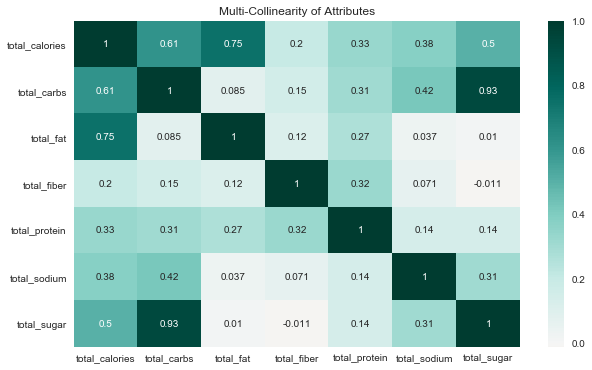

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(coll.corr(), center=0, cmap='BrBG', annot=True)

ax.set_title('Multi-Collinearity of Attributes')

Churn rate is set to be a measure of when a user stops tracking their nutritional inputs or using the app for 5 days in a row. `cutoff_date` is to clean the data further to remove users that have started using MyFitnessPal 5 days before the end of the dataset.

In [18]:
cutoff_date = datetime.strptime('2015-04-06','%Y-%m-%d')

In [19]:
print(clean_df.loc[clean_df['diary_date'] >= cutoff_date, :].shape)
print(clean_df.loc[clean_df['diary_date'] < cutoff_date, :].shape)
print(clean_df.shape)

(1074, 20)
(586113, 20)
(587187, 20)


In [20]:
clean_df = clean_df.loc[clean_df['diary_date'] < cutoff_date, :]

In [21]:
len(clean_df['userid'].unique())

9890

In [22]:
user = clean_df[clean_df['userid'] == 3]

print(user.diary_date.diff().value_counts())
print(user.diary_date.value_counts().sum())
user[user.diary_date.diff() > pd.Timedelta(3, 'D')]

1 days    5
4 days    1
Name: diary_date, dtype: int64
7


,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0,2014-10-21


In [23]:
clean_df.loc[0, 'end_date'] - clean_df.loc[0, 'diary_date']

Timedelta('1 days 00:00:00')

### Setup Data for Modeling:

Using the function `find_date`, a dataframe is setup with the start date and the time they churn for all userid's. If they have not churned, `NaT` is there to indicate "Not a Time."

In [24]:
# Create dataframe from start date to churn date
date = pd.DataFrame(find_date(clean_df))

# Find difference in amount of days between start and churn date, and set as a float
date['days'] = (date['churn_date'] - date['start_date']).dt.days

# Create new column "churn": 1 if churn_date column has a date, and 0 if it has a NaT 
date['churn'] = date['churn_date'].apply(lambda x: 0 if type(x) is not pd.Timestamp else 1)
date.head()

,churn_date,start_date,userid,days,churn
0,2014-11-01,2014-09-14,1,48.0,1
1,NaT,2015-01-12,2,NaN,0
2,2014-09-23,2014-09-14,3,9.0,1
3,2014-10-22,2014-10-21,4,1.0,1
4,NaT,2014-09-14,5,NaN,0


In [25]:
# Create a dataframe with just userid and total amount of days each user has used the app
days_count = clean_df['userid'].value_counts().sort_index()
days_count = pd.DataFrame(days_count).rename(columns={'userid': 'days_count'})
days_count.head()

,days_count
1,174
2,60
3,7
4,27
5,179


In [26]:
# Merge date and days_count dataframes
df_set = pd.merge(days_count, date, left_index=True, right_on='userid')
df_set.index = df_set['userid']
df_set = df_set.drop('userid', axis=1)

# Fill the null values in "days" with the corresponding values in "days_count"
df_set.days.fillna(df_set.days_count, inplace=True)
df_set.head()

,days_count,churn_date,start_date,days,churn
userid,,,,,
1,174,2014-11-01,2014-09-14,48.0,1
2,60,NaT,2015-01-12,60.0,0
3,7,2014-09-23,2014-09-14,9.0,1
4,27,2014-10-22,2014-10-21,1.0,1
5,179,NaT,2014-09-14,179.0,0


In [27]:
cols = clean_df.drop(['userid','diary_date'], axis=1).columns

condense = clean_df.groupby(['userid'])[cols].sum()

svl = pd.merge(df_set, condense, left_index=True, right_index=True)
svl.head()

,days_count,churn_date,start_date,days,churn,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,...,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
userid,,,,,,,,,,,,,,,,,,,,,
1,174,2014-11-01,2014-09-14,48.0,1,375085.0,46633.0,12472.0,0.0,19029.0,...,401750.0,32265.0,13562.0,0.0,22408.0,360487.0,14227.0,844699.0,867495.0,68
2,60,NaT,2015-01-12,60.0,0,90925.0,11387.0,2955.0,0.0,4714.0,...,87430.0,10872.0,2537.0,0.0,2550.0,100217.0,4573.0,208179.0,251403.0,11
3,7,2014-09-23,2014-09-14,9.0,1,9438.0,1178.0,312.0,196.0,469.0,...,11969.0,811.0,267.0,120.0,323.0,10156.0,0.0,23646.0,27693.0,2
4,27,2014-10-22,2014-10-21,1.0,1,44211.0,5524.0,1464.0,0.0,2223.0,...,24636.0,2682.0,1001.0,0.0,1153.0,40061.0,0.0,69533.0,115522.0,4
5,179,NaT,2014-09-14,179.0,0,572414.0,0.0,15948.0,7564.0,35677.0,...,536631.0,0.0,13818.0,6305.0,33720.0,358700.0,21707.0,970881.0,1064788.0,58


In [28]:
# Creates 7 new columns calculating whether or not a user has reached within 10% of their goal,
# for the duration of the time using the app
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = svl[f'total_{nutrient}']
    goal = svl[f'goal_{nutrient}']
    svl[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [29]:
svl.drop(svl.columns.difference(['days','churn','calories_10_pct','carbs_10_pct',
                                 'fat_10_pct','fiber_10_pct','protein_10_pct',
                                 'sodium_10_pct','sugar_10_pct','achievement']), 1, inplace=True)

In [30]:
# Sorting columns alphabetically to correctly pickle and deploy in flask
svl = svl.reindex(sorted(svl.columns), axis=1)

In [31]:
svl.head()

,achievement,calories_10_pct,carbs_10_pct,churn,days,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,68,1,0,1,48.0,1,0,0,1,1
2,11,1,1,0,60.0,0,0,0,0,0
3,2,0,0,1,9.0,0,0,0,0,0
4,4,0,0,1,1.0,0,0,0,0,0
5,58,1,0,0,179.0,0,0,1,0,1


### Pickled file:
Save processing time when loading into a dataframe. Here is where you can use this parsed data to test with the regression models below.

To read the file, use: `pd.read_pickle('pkl/svl.pkl')`


## Histogram Analysis 
- churn = 1
- continuous = 0

In [ ]:
svl = pd.read_pickle('pkl/svl.pkl')

Text(0.5, 1.0, 'Histogram of churned users')

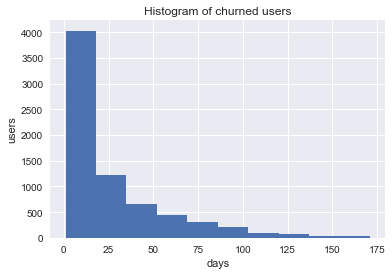

In [32]:
h = svl.loc[svl['churn'] == 1, 'days']
plt.hist(h)
plt.xlabel('days')
plt.ylabel('users')
plt.title('Histogram of churned users')

Text(0.5, 1.0, 'Histogram of current users')

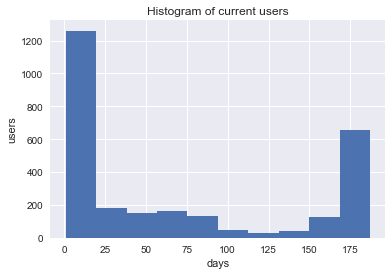

In [33]:
z = svl.loc[svl['churn'] == 0, 'days']
plt.hist(z)
plt.xlabel('days')
plt.ylabel('users')
plt.title('Histogram of current users')

In [34]:
svl['churn'].value_counts()

1    7107
0    2783
Name: churn, dtype: int64

## Logistic Regression

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, accuracy_score,
f1_score, confusion_matrix, classification_report)

In [36]:
X = svl.drop(['churn'], axis=1)
y = svl.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [37]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [38]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7753017641597029
Recall Score: 0.9488636363636364
Accuracy Score: 0.7678932470683381
F1 Score: 0.8533469596320901


**Precision** measures how precise our predictions are.     
*Precision = (True Positives / Pred Positives)*             

**Recall** tells us what percentage of the class(es) we're interested in were actually captured by the model.     
*Recall = (True Positives / Actual Total Positives)*     

**Accuracy** measures the total number of predictions our model got right, including both True Positives and True Negatives.     
*Accuracy = (True Pos + True Neg) / Total Observations*     

**F1-Score** represents the harmonic Mean of Precision and Recall. How well the model is doing overall.     
*F1-Score = 2*(Precision x Recall)/(Precision + Recall)

In [39]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.72      0.32      0.44       713
           1       0.78      0.95      0.85      1760

   micro avg       0.77      0.77      0.77      2473
   macro avg       0.75      0.64      0.65      2473
weighted avg       0.76      0.77      0.74      2473



In [40]:
p = np.array((3, 1, 0, 50, 0, 0, 0, 0, 1))
p_df = pd.DataFrame(p).T
p_df

,0,1,2,3,4,5,6,7,8
0,3,1,0,50,0,0,0,0,1


In [41]:
loreg.predict_proba(p_df).round(2)

array([[0.44, 0.56]])

AUC: 0.7029373326533215


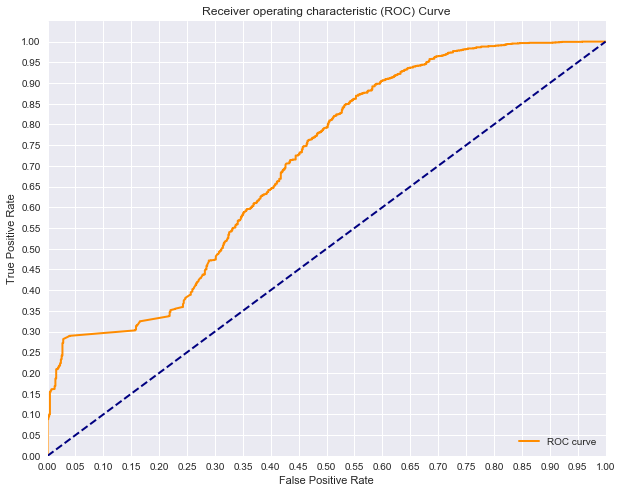

In [42]:
y_score = loreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Exporting the model as pickle file to make predictions in the flask app:

In [ ]:
pickle.dump(loreg, open("webapp/model2.pkl", "wb"))

In [ ]:
my_model = pickle.load(open("webapp/model.pkl", "rb"))

print(my_model.predict(X_test))
print(X_test.shape)

## Survival Analysis
### Cox Proportional Hazards Model:
1. duration_col = length of time between start date and time of churn - `days`
2. event_col = time of churn (when there is a break >=5 days) - `churn`

In [43]:
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter

cph_train, cph_test = train_test_split(svl, test_size=0.2)
cph = CoxPHFitter().fit(cph_train, 'days', 'churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7912 observations, 2247 censored>
      duration col = 'days'
         event col = 'churn'
number of subjects = 7912
  number of events = 5665
partial log-likelihood = -45560.80
  time fit was run = 2019-07-11 05:04:30 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.04      0.96      0.00 -32.71 <0.005    777.10       -0.04       -0.03
calories_10_pct -0.05      0.95      0.04  -1.24   0.22      2.22       -0.13        0.03
carbs_10_pct     0.06      1.06      0.04   1.30   0.20      2.36       -0.03        0.14
fat_10_pct       0.13      1.14      0.03   3.68 <0.005     12.09        0.06        0.20
fiber_10_pct     0.17      1.19      0.09   1.97   0.05      4.35        0.00        0.34
protein_10_pct  -0.13      0.88      0.05  -2.45   0.01      6.14       -0.23       -0.03
sodium_10_pct    0.08      1.08      0.04   1.76   0.08      3.68       -0.01        0.16
sugar_10_pct    

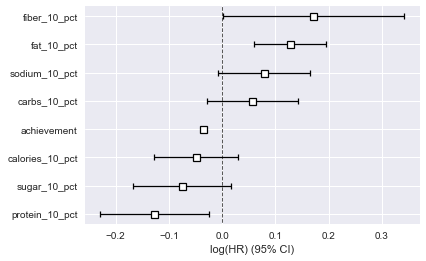

In [44]:
cph.plot()

### Results

1. We get the coefficients of our model. These are very important and they tell us how each feature increases risk, so if it’s a positive number that attribute makes a customer more likely to churn, and if it is negative then customers with that feature are less likely to churn.


2. concordance is an assessment of how internally consistent the model is – if it says a particular feature increases risk, the observations that have that feature should be more at risk. If they are the concordance goes up, if they’re not then it decreases.

Text(0.5, 1.0, 'Survival Analysis for Single Attribute')

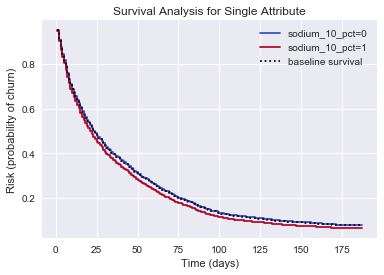

In [45]:
cph.plot_covariate_groups('sodium_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time (days)')
plt.ylabel('Risk (probability of churn)')
plt.title('Survival Analysis for Single Attribute')

Text(0.5, 1.0, 'Survival Analysis for Single Attribute')

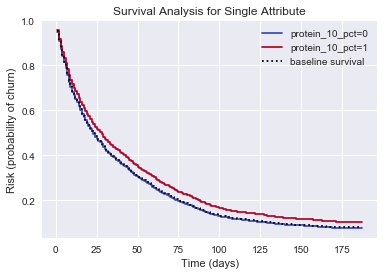

In [46]:
cph.plot_covariate_groups('protein_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time (days)')
plt.ylabel('Risk (probability of churn)')
plt.title('Survival Analysis for Single Attribute')

For example: At 25 days, there is a higher risk of churning based only on meeting protein goals. As a result, the company should provide some sort of marketing incentive for users to keep progressing at around the 25 day mark.

### P-value analysis from survival model

In [47]:
cph_train.drop(['calories_10_pct','sugar_10_pct','fiber_10_pct','carbs_10_pct'], axis=1, inplace=True)
cph = CoxPHFitter().fit(cph_train, 'days', 'churn')
cph.print_summary()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


<lifelines.CoxPHFitter: fitted with 7912 observations, 2247 censored>
      duration col = 'days'
         event col = 'churn'
number of subjects = 7912
  number of events = 5665
partial log-likelihood = -45565.45
  time fit was run = 2019-07-11 05:04:37 UTC

---
                coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement    -0.04      0.96      0.00 -33.49 <0.005    814.48       -0.04       -0.03
fat_10_pct      0.12      1.13      0.03   3.68 <0.005     12.04        0.06        0.19
protein_10_pct -0.14      0.87      0.05  -2.62   0.01      6.85       -0.24       -0.03
sodium_10_pct   0.07      1.08      0.04   1.65   0.10      3.33       -0.01        0.16
---
Concordance = 0.64
Log-likelihood ratio test = 1695.85 on 4 df, -log2(p)=inf


### Result:
While looking at the P-values, I dropped the top features with values > 0.05. This is the baseline of identifying which attributes actually affect the churn rate.

- Achieving protein and more goals in general gives a higher probability that a user will leave the app.
- Achieving fat and sodium goals will give a higher probability that a user will continue using the app.

### Survival Prediction Function

In [48]:
censored_subjects = svl.loc[svl['churn'] == 0]

unconditioned_sf = cph.predict_survival_function(censored_subjects)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[svl.loc[c.index, 'days']]).clip_upper(1))